In [1]:
from pyspark import SparkConf, SparkContext
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [2]:
def create_dataset(N, D=10, K=None):
    if K is None:
        K = math.ceil(math.sqrt(N)/2)
        
    def create_normal_dist(n):
        mu = np.random.randint(-100, 100, size=(D,))/100 * D
        L = np.random.randint(-70, 70, size=(D, D))/100
        cov = np.dot(L, L.transpose())
        
        t = np.random.multivariate_normal(mu, cov, n)
        return t
    
    dataset = list()
    Csize = N // K
    for k in range(K):
        dataset_c = np.zeros((Csize, D+1))
        dataset_c[:, 0] = np.arange(Csize, dtype=np.int32)
        dataset_c[:, 1:] = create_normal_dist(Csize)
        dataset.extend(dataset_c.tolist())
        
    return np.array(dataset)

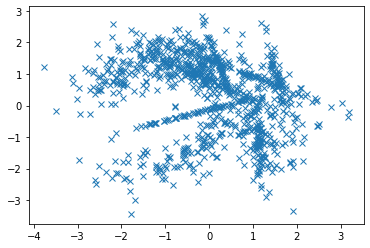

In [3]:
dataset = create_dataset(1000, D=2)
plt.plot(dataset[:, 1], dataset[:, 2], "x")

In [4]:
# conf = SparkConf().setMaster("local[4]") \
#                   .setAppName("KMeans") \
#                   .set("spark.executor.memory", "8g") \
#                   .set("spark.executor.cores", "2")

conf = SparkConf().setMaster("local").setAppName("KMeans")
sc = SparkContext(conf=conf)

In [5]:
Ns = [1000, 2000, 4000, 8000, 16000]
Ks = [10, 20, 40, 80]
THRESHOLD = 0.001
MAX_ITER = 50

In [15]:
def generate_random_centroid(dataset, K):
    indices = np.arange(len(dataset))
    randomly_selected_indices = np.random.choice(indices, size=K)
    return list(map(lambda i: (i, dataset[randomly_selected_indices[i]][1:]), range(K)))

In [7]:
def compute_square_distance(a, b):
    return np.sum((a - b)**2)

In [8]:
def assign_to_nearest_centroid(pair, centroids):
    squared_distances = list(map(lambda centroid: compute_square_distance(pair[1], centroid[1]), centroids))
    nearest_centroid_id = np.argmin(squared_distances)
            
    return nearest_centroid_id, pair[1]

In [9]:
def compute_metric(old_centroids, new_centroids):
    old_centroids = sorted(old_centroids, key=lambda item: item[0])
    new_centroids = sorted(new_centroids, key=lambda item: item[0])

    distances = map(
        lambda zipped: np.sqrt(compute_square_distance(zipped[0][1], zipped[1][1])),
        zip(old_centroids, new_centroids)
    )
    sum_of_distances = sum(distances)
    
    return sum_of_distances

In [27]:
def Kmeans(N, K):
    dataset = create_dataset(N, D=10, K=K)
    data = sc.parallelize(dataset) \
             .map(lambda pair: (int(pair[0]), np.array(pair[1:]))) \
             .cache()
    
    centroids = generate_random_centroid(dataset, K)
    print(centroids)
    centroids_rdd = sc.parallelize(centroids)
    
    # print(centroids)
    
    for i in range(MAX_ITER):
        centroids_bc = sc.broadcast(centroids)
        
        new_data = data.map(lambda pair: assign_to_nearest_centroid(pair, centroids_bc.value))
        new_centroids_rdd = new_data.groupByKey() \
                                    .mapValues(lambda value: np.mean(list(value), axis=0)) \
                                    .cache()
        new_centroids = new_centroids_rdd.collect()

        print(new_centroids)

        metric = compute_metric(centroids, new_centroids)
        if metric < THRESHOLD:
            break
        
        centroids_bc.unpersist()
        centroids_rdd.unpersist()
        
        centroids = new_centroids
        centroids_rdd = new_centroids_rdd

    data.unpersist()

In [20]:
runtimes = []

for N in Ns:
    runtimes.append([])
    for K in Ks:
        print(f"N: {N}, K: {K}")
        start_time = time.time()
        Kmeans(N, K)
        runtime = time.time() - start_time
        
        runtimes[-1].append(runtime)
        
print(runtimes)

N: 1000, K: 10
N: 1000, K: 20
N: 1000, K: 40
N: 1000, K: 80
N: 2000, K: 10
N: 2000, K: 20
N: 2000, K: 40
N: 2000, K: 80
N: 4000, K: 10
N: 4000, K: 20
N: 4000, K: 40
N: 4000, K: 80
N: 8000, K: 10
N: 8000, K: 20
N: 8000, K: 40
N: 8000, K: 80
N: 16000, K: 10
N: 16000, K: 20
N: 16000, K: 40
N: 16000, K: 80
[[20.258081197738647, 14.390682935714722, 14.732689142227173, 20.295063972473145], [20.730247259140015, 26.995254039764404, 24.84547257423401, 44.10840034484863], [23.980161428451538, 33.62977623939514, 41.529903173446655, 36.629693031311035], [40.11134076118469, 51.974268674850464, 59.13222289085388, 107.98276853561401], [69.70418214797974, 88.61410164833069, 119.45456409454346, 242.49201655387878]]


In [21]:
runtimes_np = np.array(runtimes).T

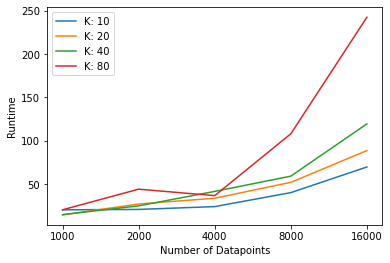

In [22]:
for i, K in enumerate(Ks):
    plt.plot(runtimes_np[i], label=f"K: {K}")
    
plt.xticks(range(len(Ns)), labels=Ns)
plt.xlabel("Number of Datapoints")
plt.ylabel("Runtime")
plt.legend()
plt.show()